In [8]:
import mhcflurry
from mhcflurry import Class1PresentationPredictor

%matplotlib inline

import re
import os
import sys
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import matplotlib.pyplot as plt
import pandas as pd
from joblib import load
from igraph import Graph as igraph_graph, plot, rescale
from IPython.display import clear_output

# adding project folder to lib search path
project = "/".join((os.path.split(os.getcwd())[0], os.path.split(os.getcwd())[1], 'scripts'))
if project not in sys.path:
    sys.path.append(project)
    
import loader
import work_with_files
import classificator_k_mer
import tree_building
import patient
import data_prep_k_mer
import quantitative_analysis
import calculating_metrics

### Functions

In [12]:
# cutting peptides into pieces

def cutting_pept(peptides, step):

    pat_pept_pieces = []

    for pepti in peptides:
        i = 9
        j = 0

        length = len(pepti)

        while i < length:

            # will drop pieces with stop codon
            if '*' in pepti[j: i]:
                #print(pepti[j: i])
                i += step
                j += step
                continue

            if pepti[j:i] not in pat_pept_pieces:
                pat_pept_pieces.append(pepti[j: i])
            i += step
            j += step
    
    return pat_pept_pieces

In [29]:
def mhc_time(pat_data, pat_hla, affinity, step):
    days_unique = list(set(sorted(pat_data.days)))
    
    days_mhc = {}
    
    for day in days_unique:
        #print(day)
        peptides = pat_data.loc[pat_data.days == day].translated
        
        #print(peptides)
        
        pat_pept_pieces = cutting_pept(peptides, step)
        
        predictor = Class1PresentationPredictor.load()

        pept_pred = predictor.predict(peptides=pat_pept_pieces,
                  alleles=pat_hla,
                  verbose=0)
        
        #clear_output(wait=True)
        #print(pept_pred.loc[pept_pred.affinity < affinity])
        
        days_mhc[day] = pept_pred.loc[pept_pred.affinity < affinity].shape[0]
        
    return days_mhc

In [30]:
# loading pat

def patient_mhc(pat_name, region, affinity, step=2):
    
    pat_hla_dict = {'p1':["HLA-A*02:02", "HLA-B*08:15"],
        'p2':["HLA-A*01:24", "HLA-B*08:39"],
        'p3':["HLA-A*02:11", "HLA-B*15:44"],
        'p5':["HLA-A*03:33", "HLA-B*14:58"],
        'p6':["HLA-A*02:02", "HLA-B*44:51"],
        'p8':["HLA-A*03:32", "HLA-B*07:40"],
        'p9':["HLA-A*25:32", "HLA-B*07:44"],
        'p10':["HLA-A*32:32", "HLA-B*44:50"],
        'p11':["HLA-A*02:32", "HLA-B*39:44"]
       }
    
    # creating df
    
    pat = patient.Patient(pat_name)

    pat_reg_data = pat.regions.region.loc[pat.regions.region.name == region]

    pat_data = pd.DataFrame(pat_reg_data['days'])

    pat_data.insert(1, 'translated', pat_reg_data.translated.apply(str))

    del pat_reg_data
    
    # pat_hla
    
    pat_hla = pat_hla_dict[pat_name]
    
    return mhc_time(pat_data, pat_hla, affinity, step)

### Patient analysis 

In [31]:
# using func

def plot_epitopes(pat_name, region, affinity, step=2):
    
    days_mhc = patient_mhc(pat_name, region, affinity, step)

    days_mhc

    days = sorted(days_mhc.keys())

    epitopes = [days_mhc[day] for day in days]

    plt.figure(figsize=(8,8))

    plt.plot(days, epitopes)
    #plt.ylim([0, 15])
    plt.xlabel('days')
    plt.ylabel('num of epitopes')
    plt.title(f'Epitopes for days (affinity_threshhold = {affinity})')

    plt.show()

/home/belsawan/anaconda3/lib/python3.7/site-packages/Bio/Seq.py:2715: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning)
/home/belsawan/Documents/hiv_project/scripts/patient.py:68: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  self.regions = Region(pd.concat([regions, self.reference.reference_df.drop(['id'], axis=1)], ignore_index=True).sort_values(by=['days']))


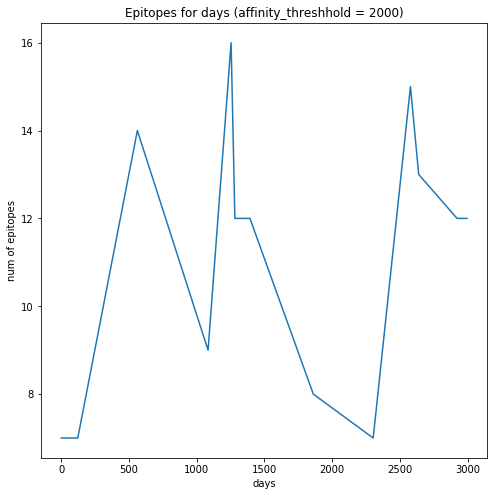

In [33]:
plot_epitopes('p1', 'V3', 2000)